In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250
mtx_opt_path = "C:/Users/Tobias Bodmer/Documents/RF_Metrics/benchmark_ours/ours_timingMatrix1627656115.npy"
taxa_values = [150, 2554, 218, 1908, 404, 1604, 714, 500, 148, 354, 885, 994, 143, 1288, 1481, 1512, 350, 2000, 141, 125, 2308, 628, 24]
tree_values = [10, 100, 500, 1000, 5000, 7500, 10000]
max_taxa_val = 10000000000
plot_store_path = "C:/Users/Tobias Bodmer/Documents/RF_Metrics/misc/plots/"
# arrays have the dimensions [numberofTrees_idx][File / number_taxa_id][metric]


In [2]:
# load matrix from file and sort
opt = np.load(mtx_opt_path, allow_pickle=True)*1e-9


num_taxa = np.array(taxa_values)
perm = np.argsort(num_taxa)
num_taxa = num_taxa[perm]
opt = opt[:,perm,:]

In [3]:
# remove too large taxa entries
t_mask = np.where(num_taxa <= max_taxa_val)
num_taxa = num_taxa[t_mask]
opt = opt[:,t_mask,:][:,0,:,:]

In [17]:
def extendedIsClose(arr, target_vals):
    return np.isclose(arr[...,None], target_vals, atol=1e-10).any(len(arr.shape))

def deleteZeroRows(inArr):
    rowsToDelete = []
    for i in range(np.shape(inArr)[0]):
        if not np.any(inArr[i]):
            rowsToDelete.append(i)
    return np.delete(inArr, rowsToDelete, 0)
def getInvalidMask(inArr):
    bad_values = np.array([0.,-1e-9,-2e-9,-3e-9,-4e-9]) # not evaluated | error | timeout
    negativeMask = extendedIsClose(inArr,bad_values)
    return ~negativeMask
def getTimeoutMask(inArr):
    bad_values = np.array([-2e-9,-3e-9,-4e-9])
    negativeMask = extendedIsClose(inArr,bad_values)
    return ~negativeMask
def getErrMask(inArr):
    bad_values = np.array([-1e-9,0])
    negativeMask = extendedIsClose(inArr,bad_values)
    return ~negativeMask

In [5]:
# analysis of data without plotting in this segment
# the metrics are nearly equally fast.

# find instances where larger tree count was faster?
# tree count is quasi transitive

# taxa is too scary to predict... just try until either fails
opt[2,:,1]

array([ 4.26786802e-01,  8.64174041e+00,  1.75678952e+01,  2.04337125e+01,
        1.91028521e+01,  2.44156814e+01,  5.88029001e+01,  1.92957961e+02,
        2.59881808e+02,  2.47725974e+02,  3.86997793e+02,  7.07239912e+02,
        9.06770084e+02, -4.00000000e-09,  1.53167579e+03,  3.57311997e+03,
       -4.00000000e-09, -4.00000000e-09, -4.00000000e-09, -4.00000000e-09,
       -4.00000000e-09, -4.00000000e-09, -4.00000000e-09])

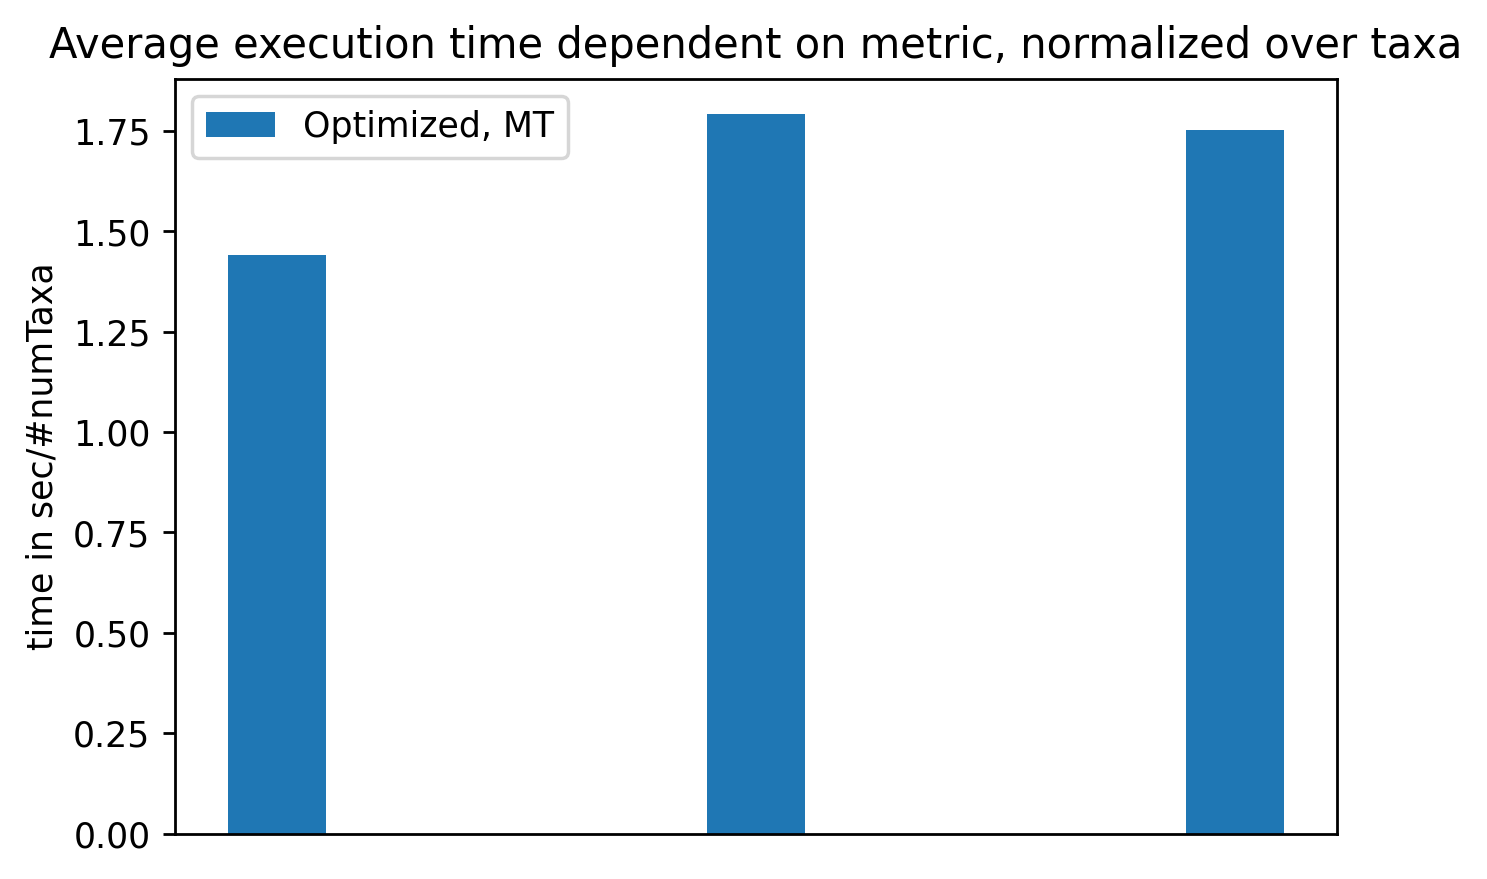

In [18]:
invM_opt = np.all(getInvalidMask(opt),axis=2)

taxa_mat = np.dstack([num_taxa]*len(tree_values))[0].T
invTaxa_opt = 1/taxa_mat[invM_opt]


weightTaxa_opt = np.einsum('ta,ta->ta',opt[invM_opt], invTaxa_opt[...,np.newaxis])

plt.bar([-5.1,-1.2,2.7], np.average(weightTaxa_opt,axis=0), label="Optimized, MT")

plt.ylabel("time in sec/#numTaxa")
plt.xlabel("MCI  |  MSI  |  SPI")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.title("Average execution time dependent on metric, normalized over taxa")
plt.legend()
plt.savefig(plot_store_path+"metricTimes",dpi=300,facecolor='white', transparent=False)
plt.show()


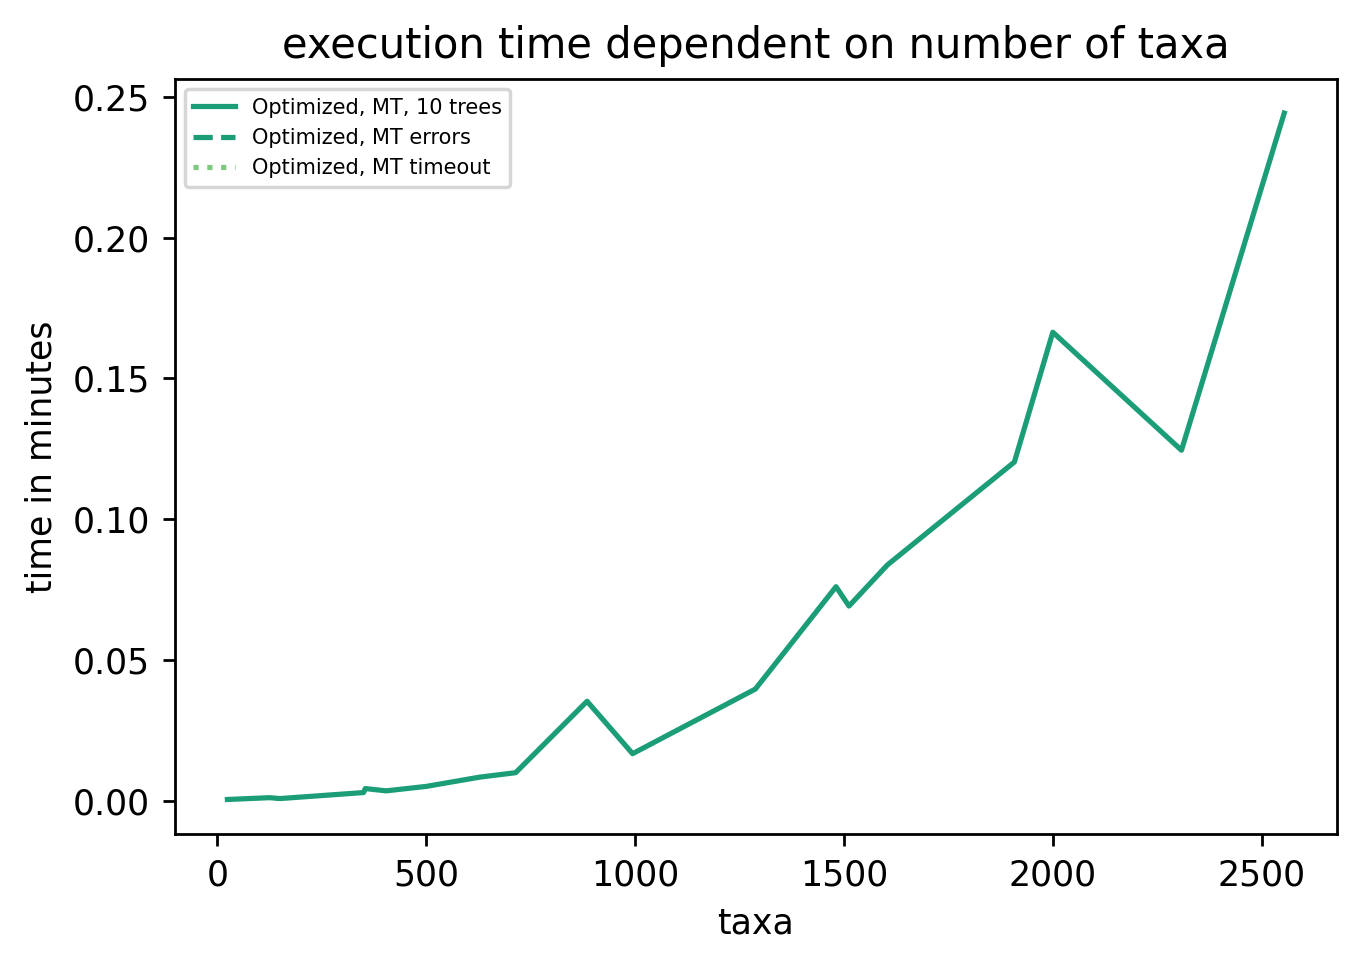

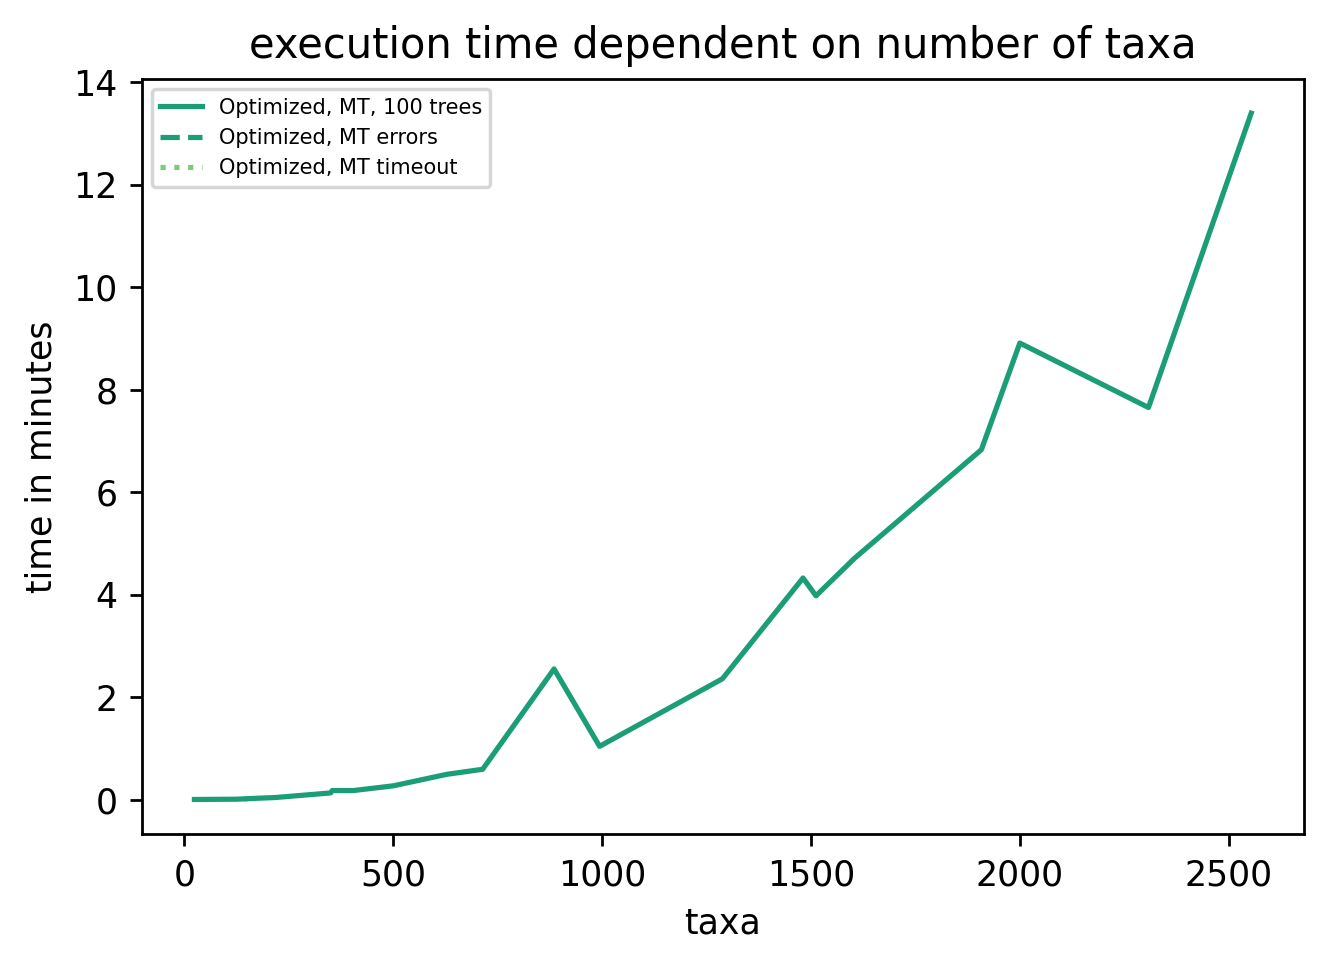

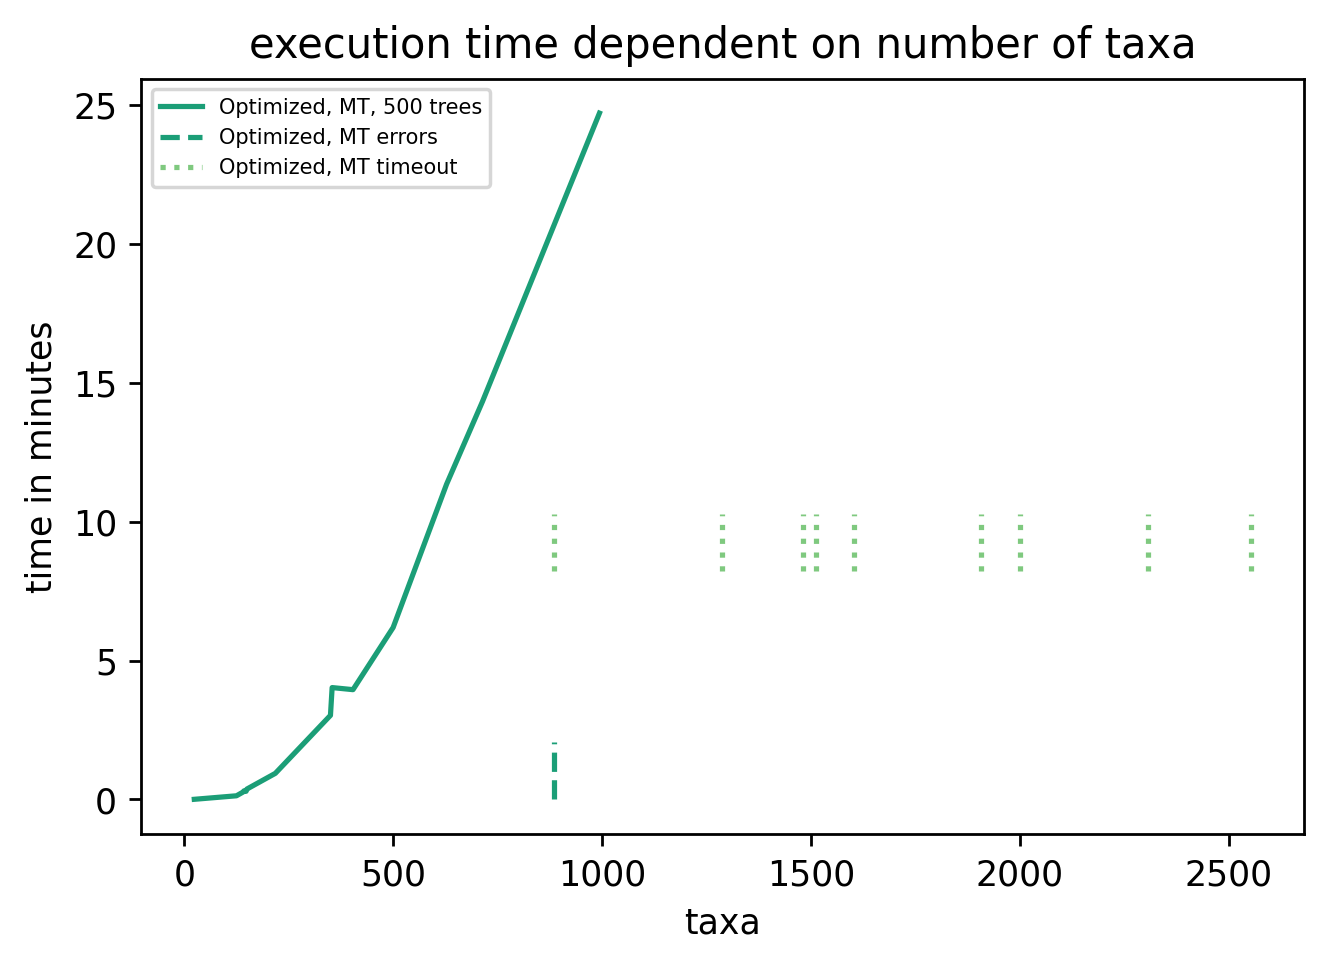

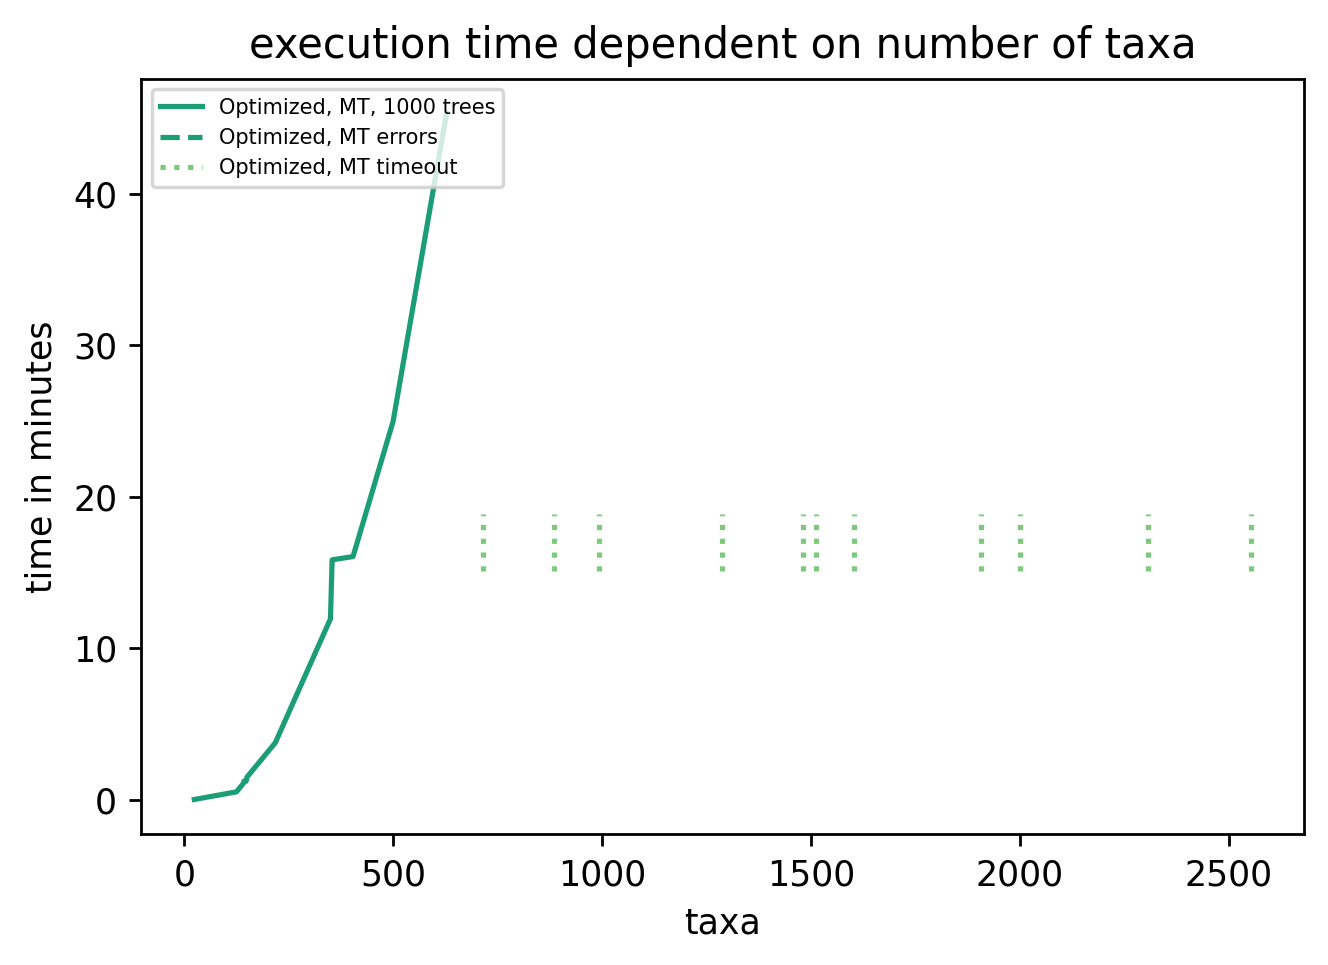

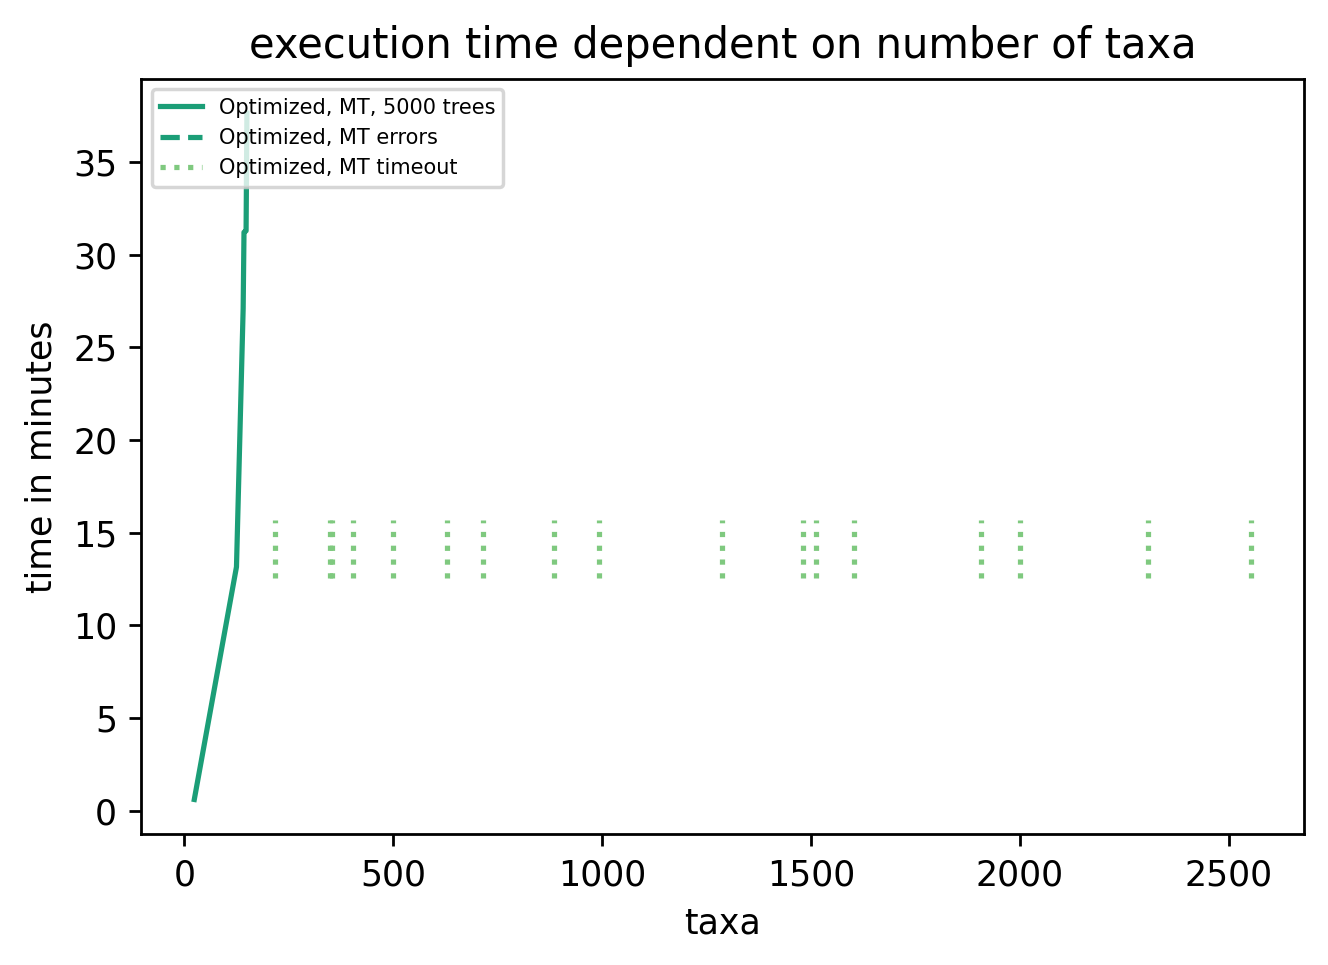

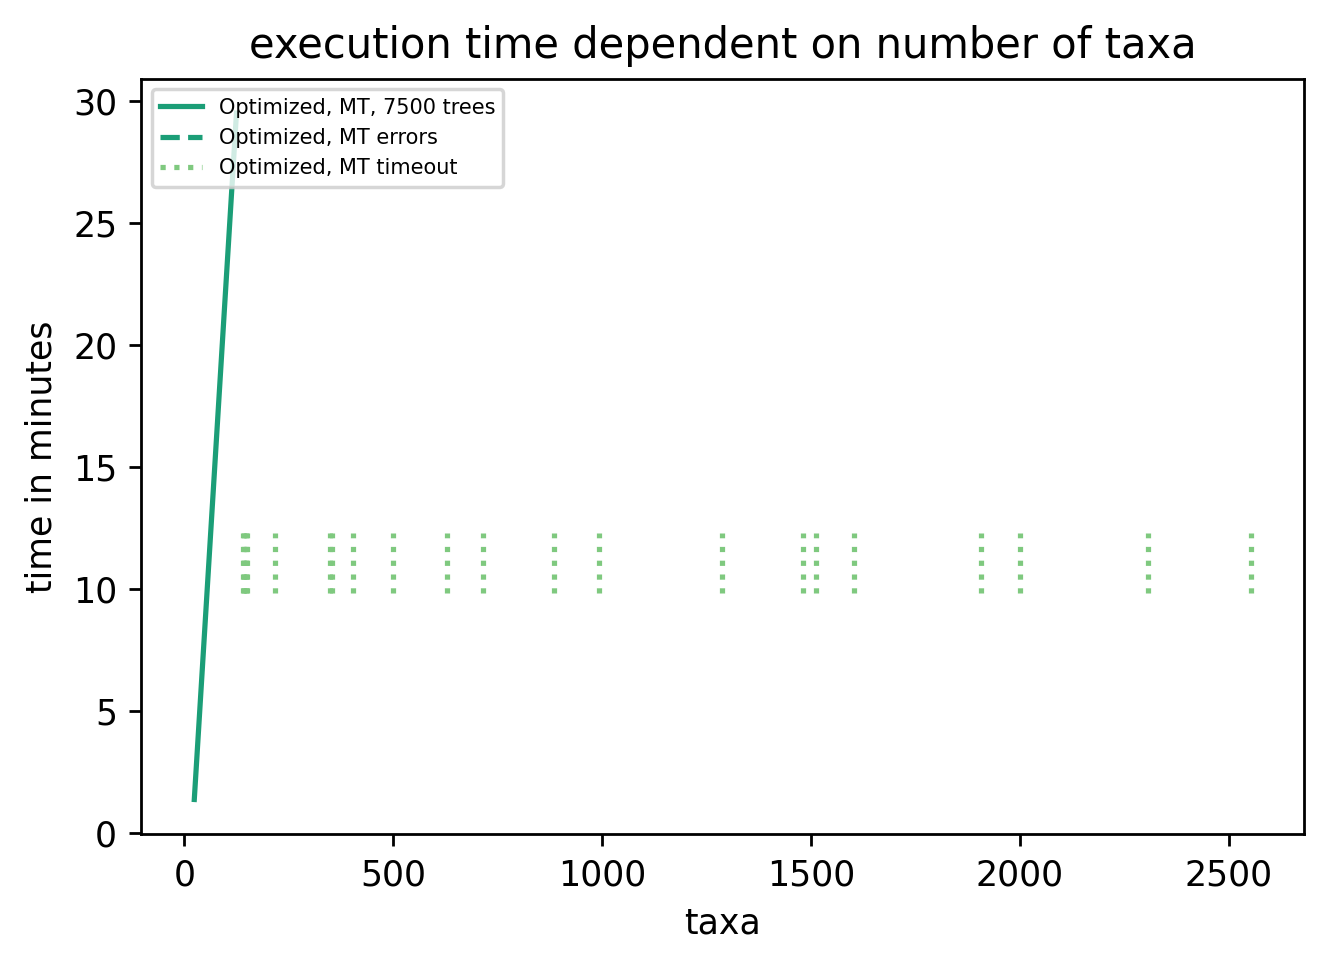

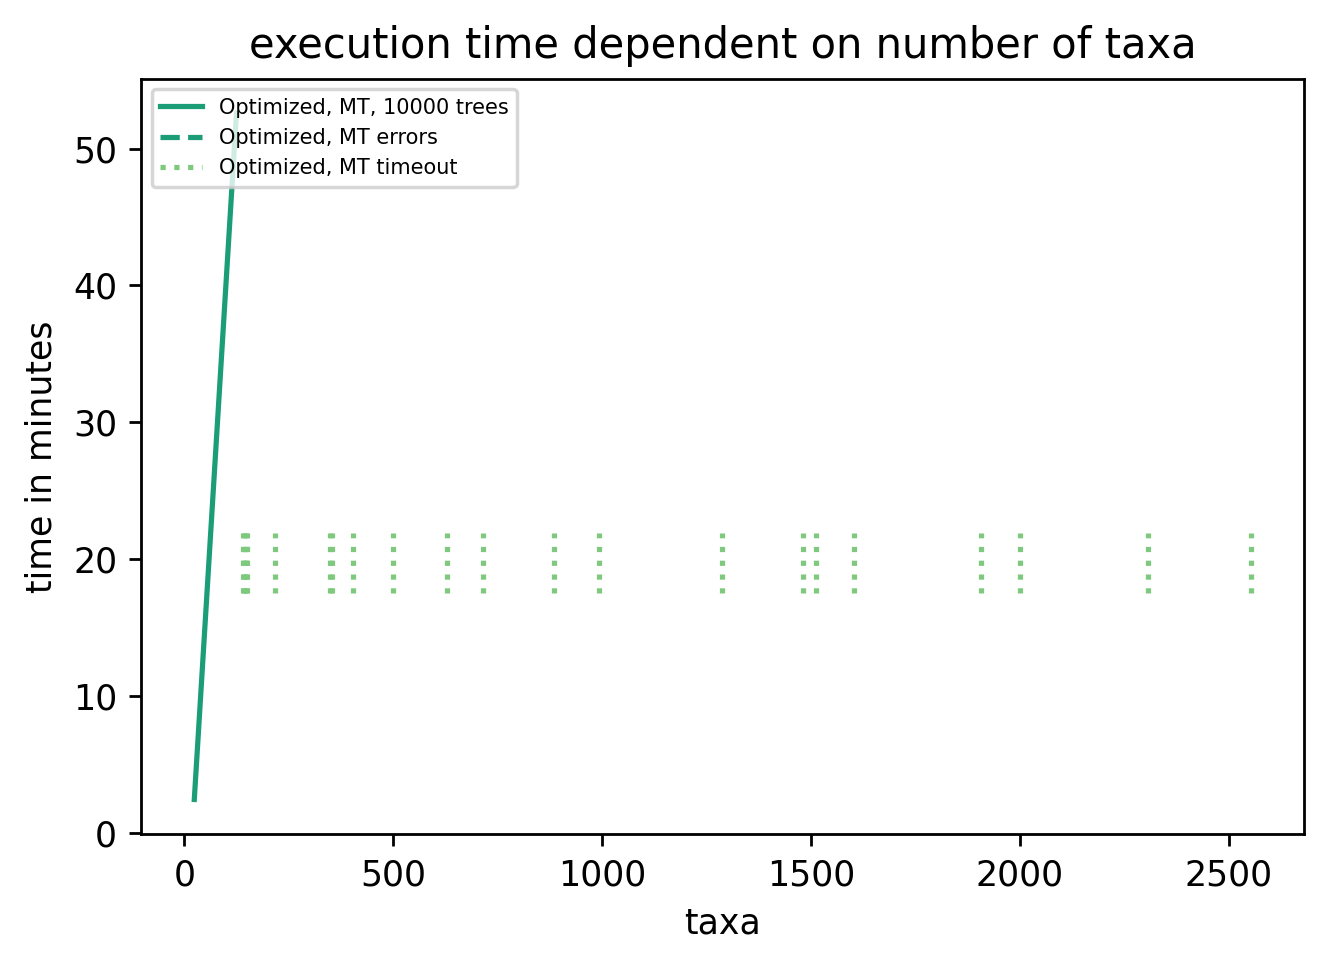

In [19]:
# plot contribution of taxa count

#need to get rid of invalid executions; np.all filters all metrics if one failed
for i, trees in enumerate(tree_values):
    # filter metrics where at least one is invalid
    invM_opt = np.all(getInvalidMask(opt[i,:,:]),axis=1)
    
    noZeros_opt = np.average(opt[i,invM_opt,:],axis=1)
   
    # plot calculations
    plt.plot(num_taxa[invM_opt], noZeros_opt/60., label = f"Optimized, MT, {trees} trees", color='#1b9e77')
   

    
    # plot errors
    memMask_opt =  np.all(getErrMask(opt),axis=2)[i,:]
    
    
    maxV = np.max(noZeros_opt) / 4. / 3. / 60.

    def plotVline(x_vals, i, lab, col, isTimeout):
        lStyle = 'dashed'
        if isTimeout:
            lStyle = 'dotted'
        plt.vlines(x_vals, i*maxV, (i+1)*maxV, label=lab, linestyle=lStyle, color=col)
    
    plotVline(num_taxa[~memMask_opt], 0.0, "Optimized, MT errors", '#1b9e77', False)

    tMask_opt =  np.all(getTimeoutMask(opt),axis=2)[i,:]

    plotVline(num_taxa[~tMask_opt], 4.0, "Optimized, MT timeout", '#7fc97f', True)
    
    plt.title("execution time dependent on number of taxa")
    plt.ylabel("time in minutes")
    plt.xlabel("taxa")
    plt.legend(loc=2, prop={'size':6})
    plt.savefig(plot_store_path+str(trees)+"treesPerf",dpi=300,facecolor='white', transparent=False )
    plt.show()


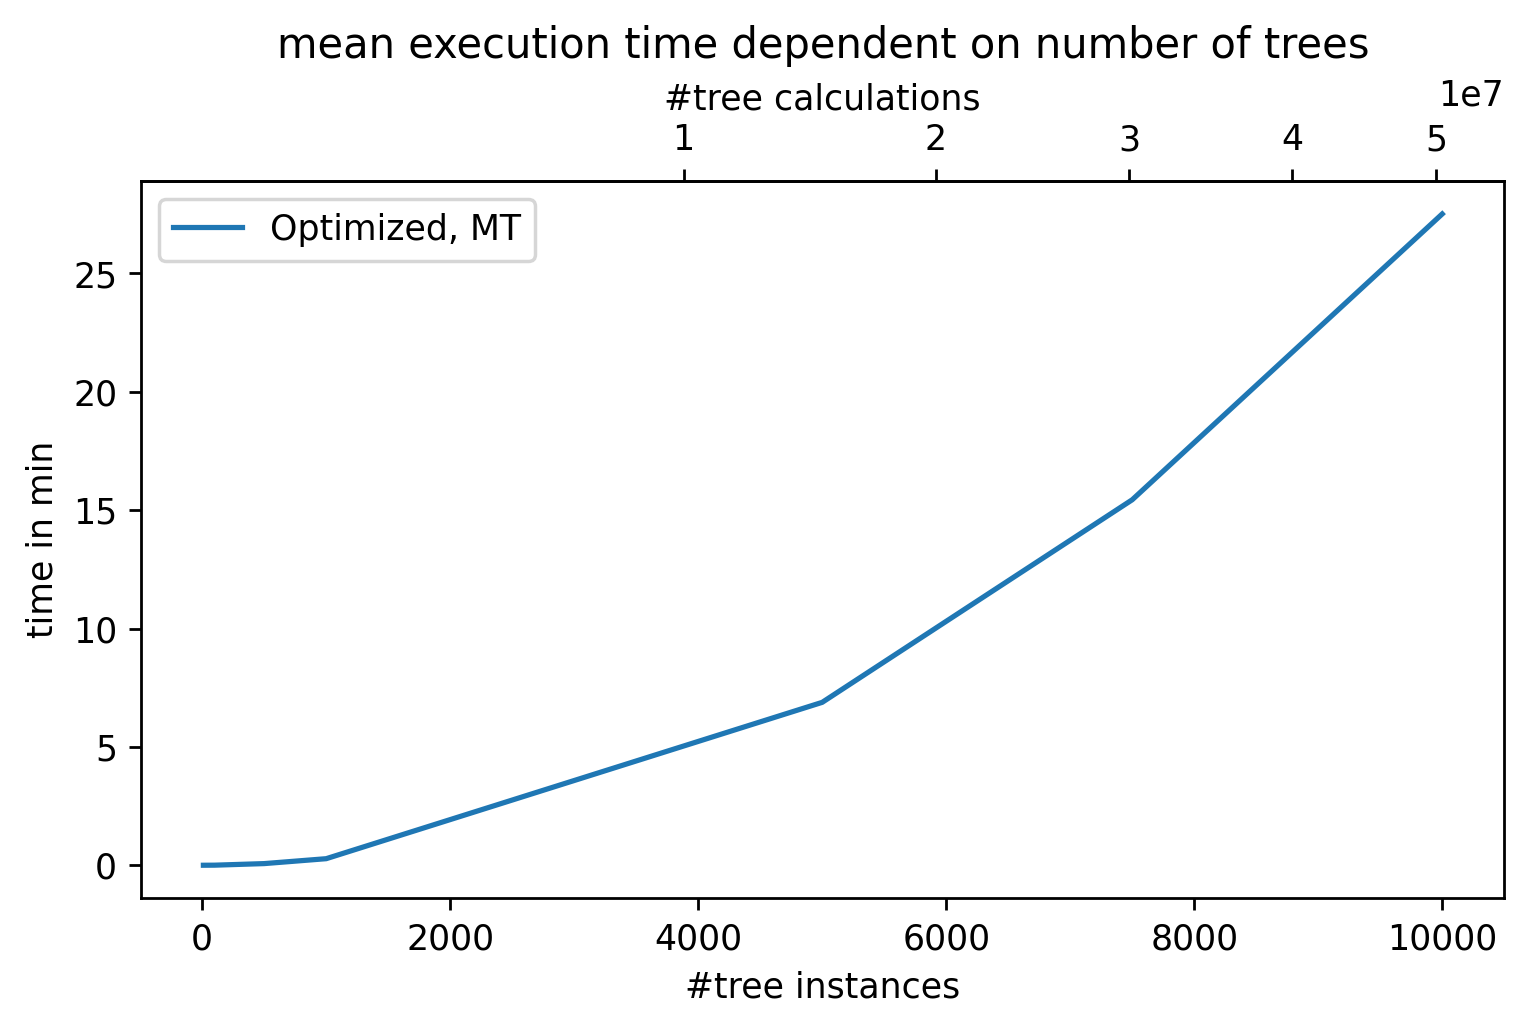

In [25]:
# plot contribution of tree count
tree_calcs = tree_values
#get first timeout event to compare fair measures
max_idx = np.argmax(~tMask_opt)

invM_opt = np.all(getInvalidMask(opt),axis=2)

if max_idx != 0 or ~tMask_opt[0] or ~tMask_unopt[0] or ~tMask_ref[0] or ~tMask_sth[0]:
    invM_opt[:,max_idx:] = False

tree_avgs_opt = []

for idx,tree in enumerate(tree_values):
    filtered_opt = opt[idx,:,:]
    tree_avgs_opt.append(np.average(filtered_opt[invM_opt[idx,:]]))

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(tree_calcs,np.array(tree_avgs_opt)/60., label="Optimized, MT")

ax.set_xlabel("#tree instances")
def trees2calc(trees):
    return trees * (trees+1)/2
def calc2trees(calc):
    return 0.5 * (np.sqrt(8*calc+1)-1)

secax = ax.secondary_xaxis('top', functions=(trees2calc, calc2trees))
secax.set_xlabel("#tree calculations")

plt.title("mean execution time dependent on number of trees")
plt.ylabel("time in min")
plt.legend()
plt.savefig(plot_store_path+"timePerTreeCalc",dpi=300,facecolor='white', transparent=False )
plt.show()